In [1]:
# Cell 1: Imports
from ultralytics import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import requests
from pathlib import Path

In [2]:
# Cell 2: Configuration
USDA_API_KEY = "WELZfmPLpRV05digWqYbzJrDHe6fauaZRav8ubiE"
USDA_BASE_URL = "https://api.nal.usda.gov/fdc/v1"

# COCO food classes (from your finding)
'''
FOOD_CLASSES = {
    46: 'banana',
    47: 'apple',
    48: 'sandwich',
    49: 'orange',
    50: 'broccoli',
    51: 'carrot',
    52: 'hot dog',
    53: 'pizza',
    54: 'donut',
    55: 'cake'
}
'''

"\nFOOD_CLASSES = {\n    46: 'banana',\n    47: 'apple',\n    48: 'sandwich',\n    49: 'orange',\n    50: 'broccoli',\n    51: 'carrot',\n    52: 'hot dog',\n    53: 'pizza',\n    54: 'donut',\n    55: 'cake'\n}\n"

In [3]:
# Cell 3: Load model
base_model_path = '../models/yolo11m.pt'
tiny_model_path = Path.home() / "calorie_estimator" / "models" / "food101_tiny_yolo11m_optimized" / "weights" / "best.pt"
pizza_model_path = Path.home() / "calorie_estimator" / "models" / "food101_pizza" / "weights" / "best.pt"
steak_model_path = Path.home() / "calorie_estimator" / "models" / "food101_steak" / "weights" / "best.pt"

model = YOLO(steak_model_path)

print("Model loaded on:", model.device)

# Get all 80 COCO classes
ALL_CLASSES = model.names  # This is a dict: {0: 'person', 1: 'bicycle', ...}
print(f"Total COCO classes: {len(ALL_CLASSES)}")
print("\nAll classes:")
'''
for idx, name in ALL_CLASSES.items():
    print(f"  {idx}: {name}")
'''

Model loaded on: cpu
Total COCO classes: 1

All classes:


'\nfor idx, name in ALL_CLASSES.items():\n    print(f"  {idx}: {name}")\n'

In [4]:
# Cell 4: Helper functions
def get_calories(food_name, api_key):
    """Get calorie info from USDA"""
    url = f"{USDA_BASE_URL}/foods/search"
    params = {
        'api_key': api_key,
        'query': food_name,
        'pageSize': 1,
        'dataType': ['Survey (FNDDS)']
    }
    
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data['foods']:
            food = data['foods'][0]
            for nutrient in food.get('foodNutrients', []):
                if nutrient['nutrientName'] == 'Energy':
                    return {
                        'food_name': food['description'],
                        'calories': nutrient['value'],
                        'unit': nutrient['unitName']
                    }
    return None

def process_image(image_path):
    """Complete pipeline: detect → get calories (ALL objects)"""
    # 1. Detect all objects
    results = model(image_path)
    result = results[0]
    
    # 2. Extract ALL detected items
    detected_items = []
    for box in result.boxes:
        class_id = int(box.cls[0])
        class_name = result.names[class_id]  # Get name from model
        confidence = float(box.conf[0])
        
        # Try to get calorie info for ANY detected object
        calorie_info = get_calories(class_name, USDA_API_KEY)
        
        detected_items.append({
            'detected_name': class_name,
            'class_id': class_id,
            'confidence': confidence,
            'calorie_info': calorie_info
        })
    
    return result, detected_items


image 1/1 /Users/jasonzhang/workspace/rmcs5112/notebooks/../data/pizza.jpg: 448x640 1 steak, 91.3ms
Speed: 2.7ms preprocess, 91.3ms inference, 0.3ms postprocess per image at shape (1, 3, 448, 640)


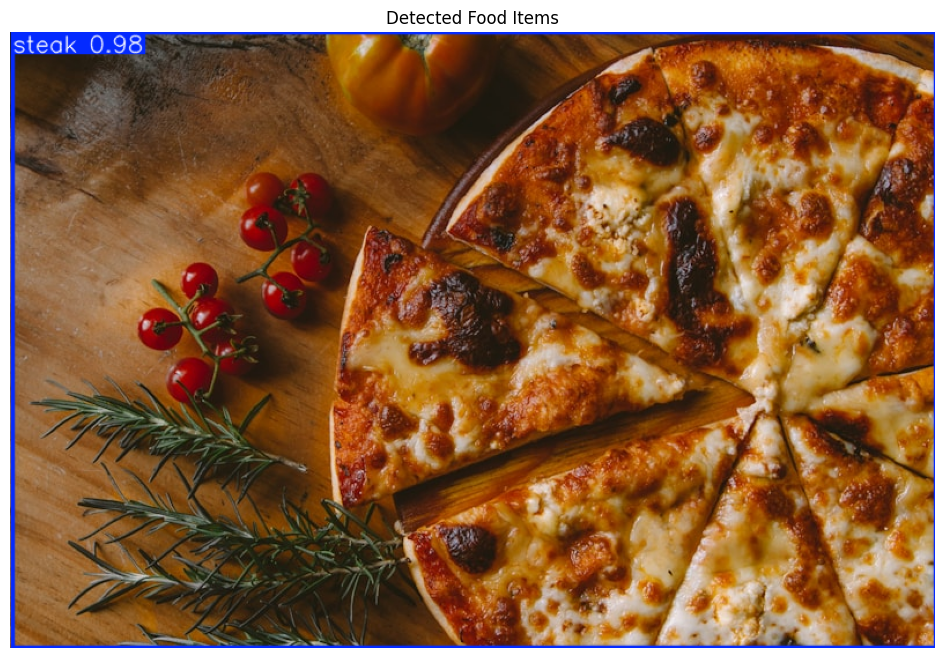


CALORIE ESTIMATION RESULTS

Detected: steak (98.28% confidence)
  → Pepper steak
  → 145 KCAL

TOTAL ESTIMATED CALORIES: 145 kcal


In [6]:
# Cell 5: Test complete pipeline
image_path = "../data/pizza.jpg"  # Use your food image

result, foods = process_image(image_path)

# Display image
img_with_boxes = result.plot()
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detected Food Items")
plt.show()

# Display calorie information
print("\n" + "="*50)
print("CALORIE ESTIMATION RESULTS")
print("="*50 + "\n")

total_calories = 0
for food in foods:
    print(f"Detected: {food['detected_name']} ({food['confidence']:.2%} confidence)")
    
    if food['calorie_info']:
        cal_info = food['calorie_info']
        print(f"  → {cal_info['food_name']}")
        print(f"  → {cal_info['calories']} {cal_info['unit']}")
        total_calories += cal_info['calories']
    else:
        print(f"  → No calorie data found")
    print()

if total_calories > 0:
    print(f"TOTAL ESTIMATED CALORIES: {total_calories:.0f} kcal")